# Image classification 

In this second part of the notebook you will solve the image classification problem using a convolutional neural network. We are going to use the torch library.


Requirements:
- Torch
- Torchvision
- Numpy
- Matplotlib

## Convolutional Neural Networks

The algorithm to classify images using a convolutional neural network consists of three steps:

1. Load the samples
2. Define the net architecture
2. Train the model with the samples

Let's implement them but, first of all, we are going to define the device where the code will run, gpu (cuda, mps) or cpu.

In [1]:
import torch

if torch.cuda.is_available():
    device_name = "cuda"
elif torch.backends.mps.is_available():
    device_name = "mps"
else:
    device_name = "cpu"
    
device = torch.device(device_name)
print(f"Code runs in {device}")


Code runs in cpu


### Step 1: Load the samples

In order to feed the net in batches, we are going to extend the class Dataset from the torch library. An instance of this class will load all the samples in a dataset (train/test). The parameter `transform` in the constructor defines a sequence of transformations to be applied to the dataset images.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import csv


class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, filename, transform = None):
        self.images, self.labels = self.load_mnist_dataset(filename)
        self.transform = transform
        
        
    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)


    def load_mnist_dataset(self, filename):
        f = open(filename, 'r')
        reader = csv.reader(f, delimiter=',')
        data = [] # not used
        images = []
        labels = []
        next(reader)
        for row in reader:
            labels.append(int(row[0]))
            images.append(np.array(row[1:]).astype(np.uint8).reshape(28,28))
        return np.array(images).astype(np.float32), np.array(labels)



Now, you can load the samples:

In [3]:
train_valid_dataset = FashionDataset("res/fashion-mnist_train.csv", transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = FashionDataset("res/fashion-mnist_test.csv", transform=transforms.Compose([transforms.ToTensor()]))

and visualize them:

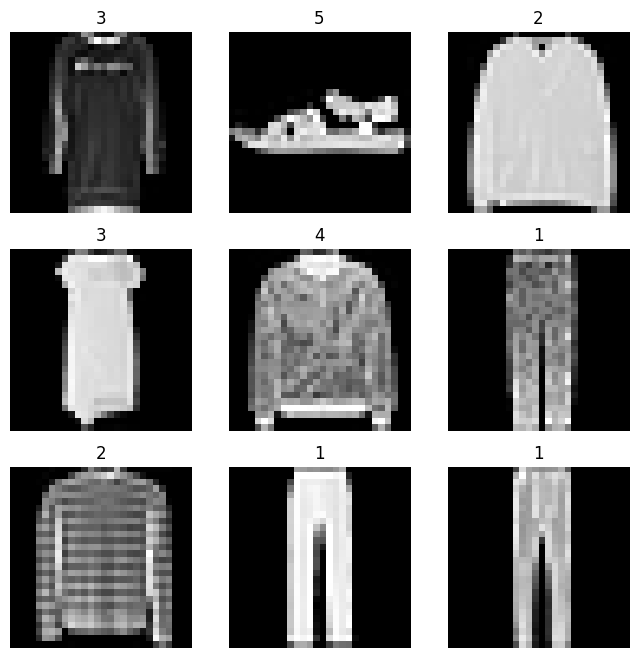

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_valid_dataset), size=(1,)).item()
    img, label = train_valid_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In deep learning, it is usual to divide the training dataset into three datasets: train, validation and test. The former is used to update the weights of the model; the second one is used to check the performance of our model during the training stage whereas the later is used to test the accuracy of the model with unseen samples. 

In our case, the Fashion-MNIST dataset consists only on a training and a test files so we are going to create a validation dataset from the training data with a 20% of the samples in this dataset.

In [6]:
VALID_RATIO = 0.2

num_train = int((1.0 - VALID_RATIO) * len(train_valid_dataset))
num_valid = len(train_valid_dataset) - num_train

print(f"Number of samples: training = {num_train} | validation = {num_valid}")

train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [num_train, num_valid])


Number of samples: training = 48000 | validation = 12000


### Step 2: Model architecture
In the second step, we are going to define the model architecture. 
We are going to start with a toy cnn with only a convolutional layer and two fully connected layers. In torch, the net is a subclass of `nn.Module`. The architecture is declared in the constructor of the class and the way the samples are feeded to the net is defined in the `forward` method:

In [7]:
import torch.nn as nn

class ToyCNN(nn.Module):

    def __init__(self):
        super(ToyCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels = 1, 
                out_channels = 32, 
                kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc1 = nn.Linear(in_features=32*12*12, out_features=600)
        self.fc2 = nn.Linear(in_features=600, out_features=10)


    def forward(self, x):
        out = self.conv1(x)
        # Flatten output of the previous conv layer to feed the next fc layer
        out = out.view(out.size(0), -1) 
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out



**Important**: This net is adapted to the Fashion-MNIST image size. The input size of the first fully connected layer depends on the size of the previous layer. In order to compute the output size of a convolutional or a pooling layer, take into account the following equation:

$output\_size = \dfrac{input\_size + 2 * padding - kernel\_size}{stride} + 1$

### Step 3: train the model

The last step is training the model with the provided samples. The following function trains  a convolutional neural network **one epoch** with the train and validation datasets: the weights are updated using the training samples and the loss is computed in the validation dataset.

In [8]:
def train(model, loader, f_loss, optimizer, device):
    count = 0
    total_loss = 0.0
    correct = 0

    model.train()
    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = f_loss(outputs, targets)

        # Accumulate the number of processed samples
        count += inputs.shape[0]

        # Accumulate the total loss
        total_loss += inputs.shape[0] * loss.item()

        # Compute total accuracy
        predictions = outputs.argmax(dim=1)
        correct += (predictions == targets).sum().item()

        # Backpropagate the error to change the model weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return total_loss/count, correct /count  


The following code trains the `ToyCNN` model one epoch using the `CrossEntropyLoss` as function loss and the `Adam` optimizer:

In [9]:
from torch.optim import Adam

model = ToyCNN()
model.to(device)

batch_size = 64
f_loss = nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(), lr=0.0001)

train_loader = DataLoader(train_dataset, batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

loss, acc = train(model, train_loader, f_loss, optimizer, device)
torch.save(model, 'trained-model.pt')
print(f"Epoch 1 (training): Loss = {loss} | Accuracy = {acc}")

Epoch 1 (training): Loss = 3.173811509271463 | Accuracy = 0.8010625


The following function computes the predictions so we can use it to check the performance of our model in the validation dataset:

In [10]:
def test(model, loader, f_loss, device):
    count = 0
    total_loss = 0.0
    correct = 0

    model.eval()
    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = f_loss(outputs, targets)

        # Accumulate the number of processed samples
        count += inputs.shape[0]

        # Accumulate the total loss
        total_loss += inputs.shape[0] * loss.item()

        # Compute total accuracy
        predictions = outputs.argmax(dim=1)
        correct += (predictions == targets).sum().item()

    return total_loss/count, correct /count  


In [11]:
loss, acc = test(model, valid_loader, f_loss, device)
print(f"Epoch 1 (validation): Loss = {loss} | Accuracy = {acc}")

Epoch 1 (validation): Loss = 1.1206585151354471 | Accuracy = 0.86475


#### Exercise
Write a function that trains the model for a given number of epochs. The function should output both validation loss and accuracy for each epoch. It should also save the model with the lowest validation error during the training stage and plot both the validation loss and accuracy through epochs. 

In [22]:
def train_model(model, train_dataset, valid_dataset, device,
                optimizer, 
                f_loss,
                batch_size=128, 
                num_epochs=20,
                output_filename='trained-model.pt'):
    
    # Needed variables
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    # Train
    for epoch in range(num_epochs):
        # Train and validate
        train_loss, train_acc = train(model, train_loader, f_loss, optimizer, device)
        val_loss, val_acc = test(model, valid_loader, f_loss, device)
        print(f"Epoch {epoch+1}  {train_loss=} {train_acc=} {val_loss=} {val_acc=}")

        # Save the model if it has the best loss or if is the first epoch
        if len(val_losses) == 0:
            torch.save(model, output_filename)
        elif min(val_losses) > val_loss:
            torch.save(model, output_filename)

        # Save information for later plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

    # Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="validation")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(train_accs, label="train")
    plt.plot(val_accs, label="validation")
    plt.legend()
    plt.show()    

Epoch 1  train_loss=0.29222116672992704 train_acc=0.9140416666666666 val_loss=0.603028028011322 val_acc=0.872
Epoch 2  train_loss=0.25202662671605747 train_acc=0.9204791666666666 val_loss=0.584916211605072 val_acc=0.8710833333333333
Epoch 3  train_loss=0.23871358361840248 train_acc=0.9239791666666667 val_loss=0.6004610233306885 val_acc=0.8720833333333333
Epoch 4  train_loss=0.2409094046751658 train_acc=0.9246041666666667 val_loss=0.6235076189041138 val_acc=0.8735833333333334
Epoch 5  train_loss=0.25862754972775776 train_acc=0.9204375 val_loss=0.6670784294605255 val_acc=0.8760833333333333
Epoch 6  train_loss=0.2795548732082049 train_acc=0.91625 val_loss=0.6231806240081788 val_acc=0.874
Epoch 7  train_loss=0.22772677929202714 train_acc=0.926375 val_loss=0.5423629698753357 val_acc=0.88525
Epoch 8  train_loss=0.18056869421402613 train_acc=0.9384166666666667 val_loss=0.5248408697446187 val_acc=0.8878333333333334
Epoch 9  train_loss=0.1630899356007576 train_acc=0.9440208333333333 val_loss=0.

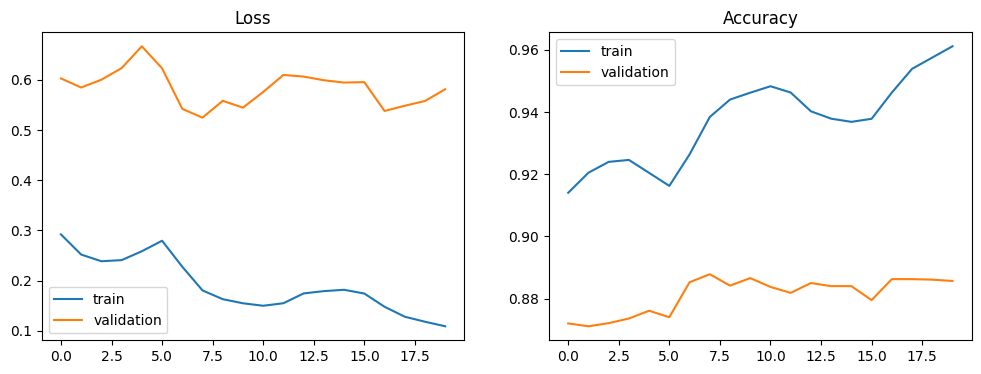

In [23]:
# IMPORTANT: adapt the batch size to your hardware requirements! 
train_model(model, train_dataset, valid_dataset, device, optimizer, f_loss, 128,20)

#### Exercise
Compute the success rate in the test dataset by loading the best model that have been saved.

In [28]:
# Load model
model = torch.load('trained-model.pt', map_location=device)
model.to(device)

# Test
test_loader = DataLoader(test_dataset, batch_size=batch_size)
test_loss, test_acc = test(model, test_loader, f_loss, device)
print(f"Test: Loss = {test_loss} | Accuracy = {test_acc}")

Test: Loss = 0.5302749317646026 | Accuracy = 0.8874


#### Exercise
Define another model architecture with two convolutional layers and three fully connected layers. Train the model and test the accuracy in the test dataset.

**Hint**: increase the learning rate (e.g. 0.001)

In [26]:
class FashionMNISTCNN(nn.Module):

    def __init__(self):
        super(FashionMNISTCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels = 1, 
                out_channels = 32, 
                kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels = 32,
                out_channels = 256,
                kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.fc1 = nn.Linear(256*4*4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)


    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


Epoch 1  train_loss=1.7779198305606843 train_acc=0.7462291666666667 val_loss=0.5475110759735108 val_acc=0.8090833333333334
Epoch 2  train_loss=0.5034490784804027 train_acc=0.8221041666666666 val_loss=0.48269959672292073 val_acc=0.8311666666666667
Epoch 3  train_loss=0.4570795025428136 train_acc=0.835375 val_loss=0.44251912490526835 val_acc=0.8425
Epoch 4  train_loss=0.41911051829655965 train_acc=0.8499375 val_loss=0.4112339462439219 val_acc=0.85325
Epoch 5  train_loss=0.39576108423868817 train_acc=0.8574583333333333 val_loss=0.405372186422348 val_acc=0.8571666666666666
Epoch 6  train_loss=0.37280295419692994 train_acc=0.8658125 val_loss=0.41020423436164855 val_acc=0.8519166666666667
Epoch 7  train_loss=0.35439709715048473 train_acc=0.8714166666666666 val_loss=0.40740548690160117 val_acc=0.8536666666666667
Epoch 8  train_loss=0.34471064678827923 train_acc=0.8751875 val_loss=0.41445493467648825 val_acc=0.8525833333333334
Epoch 9  train_loss=0.3351800781885783 train_acc=0.8780416666666667

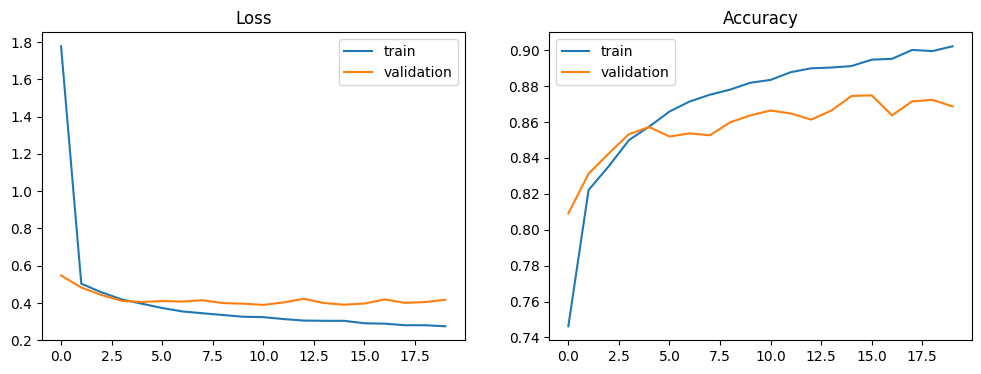

In [31]:
model = FashionMNISTCNN()
model.to(device)
optimizer=Adam(model.parameters(), lr=0.001)
train_model(model, train_dataset, valid_dataset, device, optimizer, f_loss, 128,20, 'trained-model-v2.pt')

In [32]:
# Load model
model = torch.load('trained-model-v2.pt', map_location=device)
model.to(device)

# Test
test_loader = DataLoader(test_dataset, batch_size=batch_size)
test_loss, test_acc = test(model, test_loader, f_loss, device)
print(f"Test: Loss = {test_loss} | Accuracy = {test_acc}")

Test: Loss = 0.38672497725486754 | Accuracy = 0.869


#### Exercise
Replicate the previous architecture but include [batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) before the ReLU layer and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout) between two consecutive fully conected layers. Train the  model and check if these strategies have improved the accuracy in the test dataset.

In [33]:
class FashionMNISTv2CNN(nn.Module):

    def __init__(self):
        super(FashionMNISTv2CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels = 1, 
                out_channels = 32, 
                kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels = 32,
                out_channels = 256,
                kernel_size=5),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc1 = nn.Linear(256*4*4, 512)
        self.drop = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

Epoch 1  train_loss=0.5238625233173371 train_acc=0.8213333333333334 val_loss=0.4112942663828532 val_acc=0.85675
Epoch 2  train_loss=0.33421893235047656 train_acc=0.8834166666666666 val_loss=0.347356863896052 val_acc=0.8785
Epoch 3  train_loss=0.28128696433703104 train_acc=0.9003333333333333 val_loss=0.2912457013924917 val_acc=0.89825
Epoch 4  train_loss=0.2528185900847117 train_acc=0.9108333333333334 val_loss=0.30298625445365907 val_acc=0.89625
Epoch 5  train_loss=0.22057427521546683 train_acc=0.922125 val_loss=0.3274141819477081 val_acc=0.8946666666666667
Epoch 6  train_loss=0.19131070039669673 train_acc=0.932375 val_loss=0.39448934308687844 val_acc=0.8806666666666667
Epoch 7  train_loss=0.16849939994017282 train_acc=0.941875 val_loss=0.3828650111357371 val_acc=0.8876666666666667
Epoch 8  train_loss=0.1573407452305158 train_acc=0.9435 val_loss=0.42952278860410054 val_acc=0.8793333333333333
Epoch 9  train_loss=0.13620830303430556 train_acc=0.9519166666666666 val_loss=0.4452158984343211

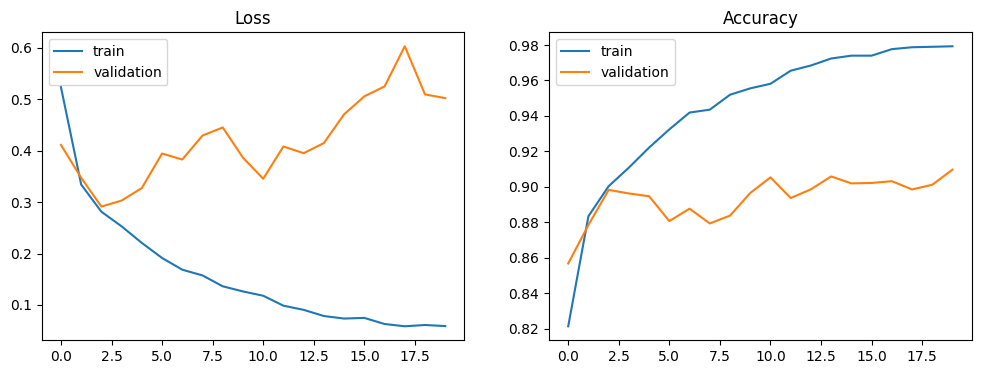

In [34]:
model = FashionMNISTv2CNN()
model.to(device)
optimizer=Adam(model.parameters(), lr=0.001)
train_model(model, train_dataset, valid_dataset, device, optimizer, f_loss, 128,20, 'trained-model-v3.pt')

In [35]:
# Load model
model = torch.load('trained-model-v3.pt', map_location=device)
model.to(device)

# Test
test_loader = DataLoader(test_dataset, batch_size=batch_size)
test_loss, test_acc = test(model, test_loader, f_loss, device)
print(f"Test: Loss = {test_loss} | Accuracy = {test_acc}")

Test: Loss = 0.27931475286483765 | Accuracy = 0.9037


Effectively, the results are improved with the last modification in the architecture.